# Ian Malone





In [36]:
# import basic libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import padasip as pa


ModuleNotFoundError: No module named 'padasip'

# PROBLEM 1

## Given information:
An unknown plant has transfer function H(z)=(1-z^(-10))/(1-z^(-1)). Note that this transfer function has weights w(n)=1 for n [0,9]. Its output is added with white Gaussian noise of power N=0.1. Its input is alpha stable noise with α=1.8 and γ=1.

#### Generate 10,000 samples of white Gaussian noise and alpha stable noise. Take the autocorrelation and power spectral density to confirm input and output.

In [2]:
# generate 10,000 samples of the white Gaussian noise

number_samples = 10000
mu = 0
std = 1
power = 0.1
white_noise = np.random.normal(mu, std*power, size=number_samples)

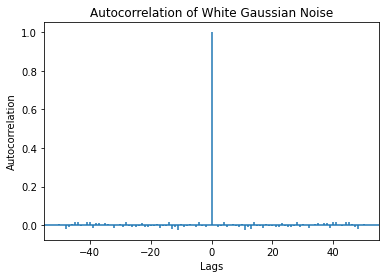

In [3]:
# plot the autocorrelation of the white Gaussian noise to confirm

plt.title("Autocorrelation of White Gaussian Noise")
plt.xlabel("Lags")  
plt.ylabel("Autocorrelation")
_ = plt.acorr(white_noise, maxlags = 50)

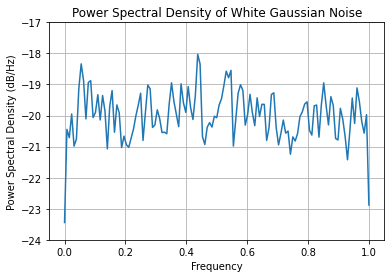

In [4]:
# plot the power spectral density of the white Gaussian noise to confirm

plt.title("Power Spectral Density of White Gaussian Noise")
_ = plt.psd(white_noise)

In [5]:
# generate 10,000 samples of the alpha stable noise

from scipy.stats import levy_stable

alpha = 1.5
gamma = 1
stable_noise = levy_stable.rvs(alpha=alpha, beta=0, loc=0, scale=gamma, size=10000)

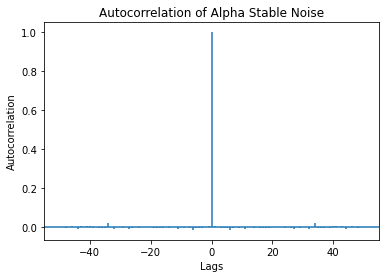

In [6]:
# plot the autocorrelation of the alpha stable noise

plt.title("Autocorrelation of Alpha Stable Noise")
plt.xlabel("Lags")  
plt.ylabel("Autocorrelation")
_ = plt.acorr(stable_noise, maxlags = 50)

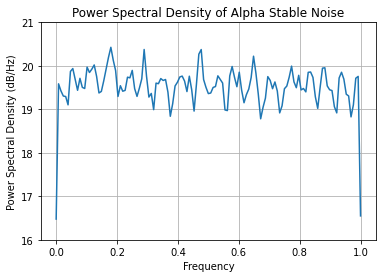

In [7]:
# plot the power spectral density of the alpha stable noise

plt.title("Power Spectral Density of Alpha Stable Noise")
_ = plt.psd(stable_noise)

In [9]:
# define optimal weight vector (known from the given transfer function)

w_star = np.array([1,1,1,1,1,1,1,1,1,1])

In [10]:
# convolve input with filter weights and add noise

output = np.convolve(stable_noise, w_star)[:10000] + white_noise

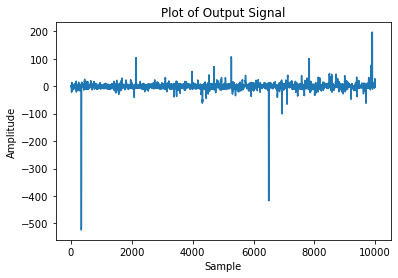

In [11]:
# plot the output

plt.title("Plot of Output Signal")
plt.xlabel("Sample")  
plt.ylabel("Amplitude")
plt.plot(output)

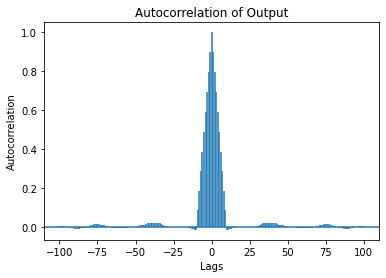

In [12]:
# plot the autocorrelation of the ouput

plt.title("Autocorrelation of Output")
plt.xlabel("Lags")  
plt.ylabel("Autocorrelation")
_ = plt.acorr(output, maxlags = 100)

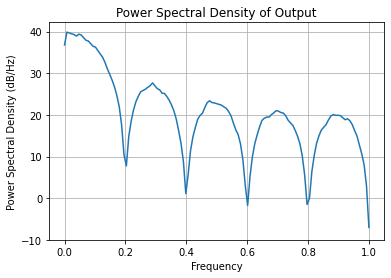

In [13]:
# plot the power spectral density of the output

plt.title("Power Spectral Density of Output")
_ = plt.psd(output)

The user has only access to the noisy output of the plant and to its input.
The goal of this problem is to design a linear filter updated with the RLS algorithm to identify the unknown plant transfer  function. 
You can NOT use the fact that you know the plant to design the adaptive filter, but you can use this knowledge to evaluate and interpret the solution obtained. 
Use the normalized MSE as the quality of the identification (normalize by the power of the input).
It is suggested that you use filters of order 5, 15, and 30. Compare the accuracy of the system identification by computing the weighted error power.

WSNR = 10 log( W∗T W∗(W∗−W(n))T (W∗−W(n)) ). 
Here W∗ is the optimal weight vector that you know because I supplied the unknown system (you have to think how to size W∗)

In [27]:
# define our accuracy metric, weighted error power (WSNR)

def wsnr(actual, ideal):
    '''Given a set of actual and ideal weights, calculate the weighted error power'''
    actual = np.array(actual)
    ideal = np.array(ideal)
    numerator = ideal.T@ideal
    denominator = (ideal-actual).T@(ideal-actual)
    return 10*np.log(numerator/denominator)

In [29]:
# define normalized MSE function

def norm_mse(real_output, ideal_output, input):
    return 'placeholder'

In [26]:
# implement the RLS algorithm



In [30]:
# find the output for RLS filter of order 5, 15, and 30



In [31]:
# calculate the quality of the identification using normalized MSE



In [32]:
# compare the accuracy of the system identification using weighted error power



# ***DISCUSS THE RESULTS OF THIS STEP HERE***

#### Show the effect of increasing the noise N(N = 0.3, 1.5) in your results. Explain what you observe.

In [33]:
# increase Gaussian noise to N=0.3 and N=1.5



In [35]:
# make plots, or show differences in WSNR, MSE....

#### Compare performance with both the Wiener solution and the LMS solution.

In [34]:
######### !!!!!!!!!! come back to this at the end... need to improve LMS results from last time

# PROBLEM 2

#### The purpose here is to design predictors using RLS algorithm and also an appropriate adaptive filter from APAs Family. The difficulty is that speech is non-stationary!


Study the effect of the filter length and the forgetting factor in the quality of the prediction. Report the best forgetting factor to track the non-stationary time series at hand.
Normalize the error power by the input signal power and use this measure to compute the
different predictors. It is suggested that you use filters of order 6 and 15.

Examine also the filter parameters and how they change over time. Can you find any similarity
on the parameters versus the similarity in the sounds? (Listen to pieces of the sound and
correlate with the parameter values)

Figure 1 shows a diagram of changes in speech spectrum over time aka spectrogram. Compare the prediction error, with major changes in the spectrogram. Discuss how this information may help you improve prediction and why convergence rate is important in this problem.

Repeat with the APA and compare with the RLS solution. Explain why you choose this APA and if it could improve the prediction.

With a goal to achieve the best prediction performance, modify the number of samples you use in the APA model to estimate the data statistics, and show how complexity is affected when changing the number of samples.